In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym.wrappers import RecordVideo


from IPython.display import HTML
from base64 import b64encode
# from pyvirtualdisplay import Display

from tqdm import tqdm

In [2]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [3]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env = RecordVideo(env, video_folder="video", name_prefix=f"Taxi")

c:\Desk\Data\Otus\OtusHomework1\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Desk\Data\Otus\OtusHomework1\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):

    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon

    return np.random.choice(np.arange(action_n), p=policy)

In [5]:
def q_learn(env, episodes, noisy_episodes, max_iterations, gamma=0.99, alpha=0.5):
    total_reward = []
    env_states = env.observation_space.n
    env_actions = env.action_space.n

    Q = np.zeros((env_states, env_actions))
    epsilon = 1

    for i in tqdm(range(episodes)):

        cumulative_reward = 0
        state, _ = env.reset()

        for j in range(max_iterations):

            policy = np.ones(env_actions) * epsilon / env_actions
            max_action = np.argmax(Q[state])
            policy[max_action] += 1 - epsilon
            act = np.random.choice(np.arange(env_actions), p=policy)
            next_state, reward, done, _, _ = env.step(act)            

            Q[state][act] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][act])

            cumulative_reward += reward

            env.render()

            if done:
                break

            state = next_state

        epsilon = max(0, epsilon - 1 / noisy_episodes)

        total_reward.append(cumulative_reward)

    return total_reward, Q

In [6]:
model = q_learn(env, episodes=800, noisy_episodes=700, max_iterations=300)
total_rewards = model[0]
agent = model[1]

100%|██████████| 800/800 [03:14<00:00,  4.12it/s]


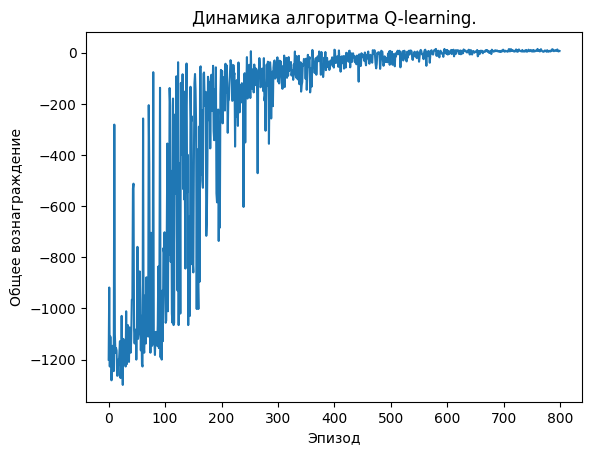

In [7]:
plt.plot(total_rewards)
plt.title('Динамика алгоритма Q-learning.')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

In [8]:
HTML(
    render_mp4(f"video/Taxi-episode-{max([int(i.split('.')[0].split('-')[-1]) for i in os.listdir('video')])}.mp4")
    )

In [17]:
def run_trained_agent(env, Q, episodes=1, t_max=500, record_video=True, video_path="video"):
   """
   Запускает агент с уже обученной Q-таблицей и при желании записывает видео.
   """

   #A) Если хотим записывать видео, оборачиваем env в RecordVideo
   if record_video:
       env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)
       # episode_trigger=lambda e: True означает, что каждый эпизод записываем.
        # Можно делать условие, например, писать только отдельные эпизоды.

   for ep in range(episodes):
       state, _ = env.reset()
       total_reward = 0
       print(f"=== Эпизод {ep+1} ===")

       for t in(t_max):
           # Выбираем действие, которое максимально по Q
           action = np.argmax(Q[state])
           next_state, reward, done, _, _ = env.step(action)
           
           # Если хотите отрисовку на экран (не только в видео), можно оставить:
           # env.render            total_reward += reward
           state = next_state

           if done:
               print(f"Эпизод завершён за {t+1} шагов. Награда: {total_reward}\n")
               break

   # (B) В конце нужно закрыть окруж чтобы корректно "собрать" видео
   env.close()

In [18]:
run_trained_agent(env, agent)

=== Эпизод 1 ===
Эпизод завершён за 11 шагов. Награда: 10

